<a href="https://colab.research.google.com/github/saif-byte/DataSciencePortfolio/blob/main/Total%20Order%20predictor/Predicting_total_orders_on_a_given_day.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting total orders on a given day

In this project we will predict the target number of orders that a company can deliver. The dataset is from UCL Machine Learning Repo named as [Daily Demand Forecasting Orders Data Set](https://archive.ics.uci.edu/ml/datasets/Daily+Demand+Forecasting+Orders#). The database was collected during 60 days, this is a real database of a Brazilian company of large logistics. Twelve predictive attributes and a target that is the total of orders for daily treatment.
We will use different regression models to predict our target value 



In [412]:
#importing necessary libraries
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.metrics import mean_squared_error , ConfusionMatrixDisplay
from matplotlib import pyplot as plt
import seaborn as sns
import re

%matplotlib inline

In [413]:
df = pd.read_csv("/content/Daily_Demand_Forecasting_Orders.csv" , sep=';')

In [414]:
df.head()

,"Week of the month (first week, second, third, fourth or fifth week",Day of the week (Monday to Friday),Non-urgent order,Urgent order,Order type A,Order type B,Order type C,Fiscal sector orders,Orders from the traffic controller sector,Banking orders (1),Banking orders (2),Banking orders (3),Target (Total orders)
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,"539.577,,,"
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,"224.675,,,"
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,"129.412,,,"
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,"317.120,,,"
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,"210.517,,,"


In [415]:
#As we can see that in last column there are additional commas , so need to remove it. Also convert to numeric type
#Also we need to take whole number in total orders column.
df['Target (Total orders)'] = pd.to_numeric([re.sub(r'[,+]','', str(x)) for x in df['Target (Total orders)']])
df['Target (Total orders)'] = df['Target (Total orders)'].round(decimals = 0)

In [416]:
len(df)

60

In [417]:
#now we need to remove inconsistencies from the column names
df.columns = df.columns.str.replace(" " , "_").str.lower()
df = df.rename(columns={'week_of_the_month_(first_week,_second,_third,_fourth_or_fifth_week': 'week_of_the_month', 'day_of_the_week_(monday_to_friday)': 'day_of_the_week' , 'target_(total_orders)':'total_orders'})
df.head()

,week_of_the_month,day_of_the_week,non-urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,orders_from_the_traffic_controller_sector,banking_orders_(1),banking_orders_(2),banking_orders_(3),total_orders
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,540.0
1,1,5,128.633,96.042,38.058,56.037,130.580,0.000,40419,21399,89461,7679,225.0
2,1,6,43.651,84.375,21.826,25.125,82.461,1.386,11992,3452,21305,14947,129.0
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.0
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,211.0


In [418]:
#now our column of interest is "total_orders", we will train a model to predict total_orders.


##Target Variable Analysis 

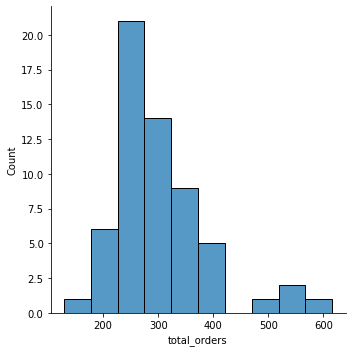

In [419]:
#We need to have a close look at our target var. 
sns.displot(df["total_orders"],kde=False)

In [420]:
#we can see that most of the orders of the orders delievered in a day are around 350, Also the graph has
#smaller tail, this means values are not far away from head.

In [421]:
#now we will check for any missing values in dataset
df.isnull().sum()

week_of_the_month                            0
day_of_the_week                              0
non-urgent_order                             0
urgent_order                                 0
order_type_a                                 0
order_type_b                                 0
order_type_c                                 0
fiscal_sector_orders                         0
orders_from_the_traffic_controller_sector    0
banking_orders_(1)                           0
banking_orders_(2)                           0
banking_orders_(3)                           0
total_orders                                 0
dtype: int64

In [422]:
#there are no null values in columns.

In [423]:
#now we will split our data into train , test, and validation set
n = len(df)
n_train = int(0.6*n)
n_test = int(0.2*n)
n_val = int(0.2*n)
#fixing random seed , so dfs are reproducible
np.random.seed(2)
#getting shuffled index
idx = np.arange(n)
np.random.shuffle(idx)

#using shuffled index to get shuffled df
df_shuffled = df.iloc[idx]

df_train = df_shuffled[:n_train].copy()
df_test = df_shuffled[n_train:n_train+n_test].copy()
df_val = df_shuffled[n_train+n_test:].copy()

In [424]:
#now our data is splitted and shuffled
df_train.head()

,week_of_the_month,day_of_the_week,non-urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,orders_from_the_traffic_controller_sector,banking_orders_(1),banking_orders_(2),banking_orders_(3),total_orders
36,5,2,381.768,140.041,118.178,260.632,152.134,9.135,34236,194216,136035,47601,531.0
0,1,4,316.307,223.270,61.543,175.586,302.448,0.000,65556,44914,188411,14793,540.0
47,3,4,127.805,114.813,39.025,110.740,94.470,1.617,33366,21103,84558,16683,244.0
55,5,2,158.716,158.133,59.131,92.639,165.079,0.000,32027,33282,128269,9287,317.0
23,2,2,266.741,141.437,58.721,139.034,211.646,1.223,58081,43333,135314,29716,409.0


In [425]:
df_test.head()

,week_of_the_month,day_of_the_week,non-urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,orders_from_the_traffic_controller_sector,banking_orders_(1),banking_orders_(2),banking_orders_(3),total_orders
51,4,3,150.257,116.959,34.193,115.536,118.911,1.424,51346,19782,89704,12182,269.0
33,4,4,235.106,110.874,70.376,154.242,121.417,55.000,23257,163452,63699,33805,346.0
4,2,3,90.532,113.526,37.679,56.618,116.220,6.459,48534,19646,16411,20257,211.0
38,5,4,193.957,111.859,47.002,99.892,159.462,540.000,59179,94460,54772,34616,306.0
3,2,2,171.297,127.667,41.542,113.294,162.284,18.156,49971,33703,69054,18423,317.0


In [426]:
df_val.head()

,week_of_the_month,day_of_the_week,non-urgent_order,urgent_order,order_type_a,order_type_b,order_type_c,fiscal_sector_orders,orders_from_the_traffic_controller_sector,banking_orders_(1),banking_orders_(2),banking_orders_(3),total_orders
31,3,5,170.868,131.463,45.550,120.548,157.505,21.272,42534,79556,50433,36483,324.0
34,4,5,168.179,125.119,71.068,100.544,136.033,14.347,28072,95989,50763,55445,308.0
7,2,6,119.379,113.870,38.584,85.961,124.413,15.709,35033,26278,56665,18502,249.0
59,5,6,192.116,121.106,107.568,121.152,103.180,18.678,27328,108072,56015,10690,332.0
11,3,5,145.865,91.180,43.851,66.277,133.440,6.523,66910,17768,36693,29046,244.0


In [427]:
#now we need to get actual target values for each spilitted df
y_train = df_train["total_orders"]
y_test = df_test["total_orders"]
y_val = df_val["total_orders"]


In [428]:
#also we need to delete y values from splitted dataset , so we don't use them accidentally
del(df_train["total_orders"])
del(df_test["total_orders"])
del(df_val["total_orders"])

In [429]:
#our numerical features are
base = ['non-urgent_order','urgent_order','order_type_a','order_type_b','order_type_c','fiscal_sector_orders',
        'orders_from_the_traffic_controller_sector', 'banking_orders_(1)'	,'banking_orders_(2)','banking_orders_(3)']

In [430]:
#as we can see that we have some categorical variable such as week_of_the_month and day_of_the_week
#we need to prepare them for our model
def prepare_X(df):
  df = df.copy()
  features = base.copy()
  for v in [1,2,3,4,5]:
    feature = '%s_week_of_the_month'%v
    df[feature] = (df['week_of_the_month']==v).astype(int)
    features.append(feature)
  for v in [2,3,4,5,6]:
    feature = '%s_day_of_the_week'%v
    df[feature] = (df['day_of_the_week']==v).astype(int)
    features.append(feature)
  df_num = df[features]
  return df_num

In [431]:
#now we will train our model on df_train 
reg = linear_model.LinearRegression()
X_train = prepare_X(df_train)
reg.fit(X_train , y_train)

LinearRegression()

In [432]:
#now we will take a look at individual weights 
reg.coef_

array([-1.94572819e-02, -1.94004498e-02,  1.03500000e+00,  1.00801094e+00,
        1.01709963e+00, -7.12274491e-04,  6.10263179e-07,  2.58847762e-06,
        1.12313456e-05,  1.57406383e-06,  1.03462724e-01,  7.52220651e-02,
       -8.96650184e-02,  1.32310442e-01, -2.21330213e-01, -1.75890044e-01,
        1.54891448e-01,  1.04459185e-01, -3.87326811e-02, -4.47279082e-02])

In [433]:
#alse we take a look at base weights 
reg.intercept_

-0.4897783479704003

In [434]:
#now we will predict the values of our validation set 
X_val  = prepare_X(df_val)
y_pred = reg.predict(X_val)

In [435]:
#now compare the predicted values with actual values , we will use rmse method
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
rmse

0.5050535538649148

In [436]:
#As we can see that our model has very small rmse, it means it has learned very well.
#Let us look , if we use ridge regression can we improve our model
#we will check for multiple values of alpha
for a in [0.0001,0.001 , 0.01 , 0.1 , 1 , 10, 15]:
  ridge = linear_model.Ridge(alpha = a)
  ridge.fit(X_train, y_train)
  X_val = prepare_X(df_val)
  y_pred = ridge.predict(X_val) 
  #let us check rmse
  rmse = np.sqrt(mean_squared_error(y_val, y_pred))
  print(a , rmse)

0.0001 0.5050373224744571
0.001 0.5048913531645979
0.01 0.5034427790202075
0.1 0.4899891570098272
1 0.41399450285503386
10 0.3573013044722597
15 0.3860713366813574


In [437]:
#As we can see that for any value of alpha , the model is etting better than linear regression model, so we 
#chose ridge regression with alpha = 1 model as our final model.

In [438]:
#now let us see how well does our model do on test set
ridge = linear_model.Ridge(alpha = 1)
ridge.fit(X_train, y_train)
X_test = prepare_X(df_test)
y_pred = ridge.predict(X_test)

#calculating rmse
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('rmse for validation set is 0.3573')
print(f'rmse for test set is {rmse}')


rmse for validation set is 0.3573
rmse for test set is 0.40009875633902864


In [439]:
#As we can see that our model has also performed well on test set

Now let us assume the business gets following orders on a day

In [440]:
order = {
    'week_of_the_month':2,
    'day_of_the_week': 5,
    'non-urgent_order':118.552,
    'urgent_order':100.417,
    'order_type_a':54.401,
    'order_type_b':75.61,
    'order_type_c':105.584,
    'fiscal_sector_orders':16.629,
    'orders_from_the_traffic_controller_sector':40423.000,
    'banking_orders_(1)':24682.000,
    'banking_orders_(2)':47563.000,
    'banking_orders_(3)':35314.000}
order = pd.DataFrame([order])

order = prepare_X(order)
y_pred = ridge.predict(order)
y_pred

array([235.80695149])

**As we can see that our model predicted the 235.8 total orders while the original total orders were 235, that's mean our model predicted right value**

We used two different model that is linear regression and ridge regression, we found out that our model learned well using ridge regression so we used that with alpha value of 1. 
This model can further be used to evaluate employee performance by predicting the target orders before. 
